In [1]:
%load_ext autoreload
%autoreload 2

# Import packages

In [2]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report, silhouette_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc 
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier



warnings.filterwarnings('ignore')

# Loading the data

In [3]:
load_dotenv()

True

In [4]:
data_get_env =os.getenv("DATA_HR")

In [5]:
# Set the working directory
os.chdir('/Users/felixhaberl/code/Emroullier/hr-data-analytics')

In [6]:
print(os.getcwd())

/Users/felixhaberl/code/emroullier/hr-data-analytics


In [7]:
data = pd.read_csv(data_get_env)

In [8]:
data.head(5)

,ID,Name,Department,GEO,Role,Rising_Star,Will_Relocate,Critical,Trending Perf,Talent_Level,...,Emp_Competitive_4,Emp_Competitive_5,Emp_Collaborative_1,Emp_Collaborative_2,Emp_Collaborative_3,Emp_Collaborative_4,Emp_Collaborative_5,Sensor_StepCount,Sensor_Heartbeat(Average/Min),Sensor_Proximity(1-highest/10-lowest)
0,1,BRADDY,Operations,US,VP,NaN,0,1.0,3,6,...,2,2,2,2,2,1,5,1841,61,9
1,2,BORST,Sales,UK,Senior Director,NaN,0,NaN,3,6,...,4,1,3,2,5,1,5,1990,90,8
2,3,BIRDWELL,Finance,France,Senior Director,NaN,0,NaN,3,6,...,2,5,2,2,4,4,4,3193,80,8
3,4,BENT,Human Resources,China,Senior Director,NaN,0,NaN,3,6,...,5,1,1,2,4,4,1,3248,77,6
4,5,BAZAN,IT,Korea,Director,NaN,0,NaN,3,6,...,5,3,5,1,2,5,4,3149,80,10


# Data Preparation

In [9]:
data.drop(columns = ['ID','Name','Rising_Star', 'Trending Perf', 'Talent_Level',
                     'Validated_Talent_Level', 'EMP_Sat_OnPrem_1', 'EMP_Sat_OnPrem_2',
                     'EMP_Sat_OnPrem_3','EMP_Sat_Remote_3', 'EMP_Sat_Remote_4','EMP_Sat_Remote_5',
                     'EMP_Engagement_2','EMP_Engagement_3','EMP_Engagement_4',
                     'EMP_Engagement_5','CSR Factor','sales'], inplace = True)

data = data.rename(columns={
    'Sensor_Heartbeat(Average/Min)': 'Sensor_Heartbeat',
    'Sensor_Proximity(1-highest/10-lowest)': 'Sensor_Proximity'
})

In [10]:
# Convert column names to lower snake case
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '_')

In [11]:
# combine all the men_leave and the women_leave column

data['leave'] = data['women_leave'].fillna(data['men_leave'])
data['leave'] = data['leave'].fillna(0)
data.drop(columns = ['women_leave', 'men_leave'], inplace = True)


# General Prerequisites

In [12]:
# checking missing values

data.isnull().sum().sort_values(ascending=False)


critical                 14519
emp_sat_onprem_4           128
emp_sat_onprem_5           128
department                   0
emp_competitive_5            0
emp_identity                 0
emp_role                     0
emp_position                 0
emp_title                    0
emp_competitive_1            0
emp_competitive_2            0
emp_competitive_3            0
emp_competitive_4            0
emp_collaborative_2          0
emp_collaborative_1          0
emp_work_status_4            0
emp_collaborative_3          0
emp_collaborative_4          0
emp_collaborative_5          0
sensor_stepcount             0
sensor_heartbeat             0
sensor_proximity             0
emp_work_status_5            0
emp_work_status2             0
emp_work_status_3            0
number_project               0
role                         0
will_relocate                0
percent_remote               0
emp_sat_remote_1             0
emp_sat_remote_2             0
emp_engagement_1             0
last_eva

In [13]:
# impute binary missing values for critical column

data.loc[data['critical'].isna(), 'critical'] = 0


In [14]:
# covert gender column into binary classification column

data['gender'] = data['gender'].map({'F': 1, 'M': 0})


In [15]:
# impute missing values with mode as these are ranking/ordinal columns
columns_to_impute = ['emp_sat_onprem_4', 'emp_sat_onprem_5']

imputer = SimpleImputer(strategy='most_frequent')

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])


In [16]:
# target imbalancing
# the target is imbalanced, however this can be sorted using the class_weight='balanced' when using LogisticRegression

data['left_company'].value_counts(normalize = True)


left_company
0    0.761917
1    0.238083
Name: proportion, dtype: float64

# Numerical Features Data Cleaning ONLY

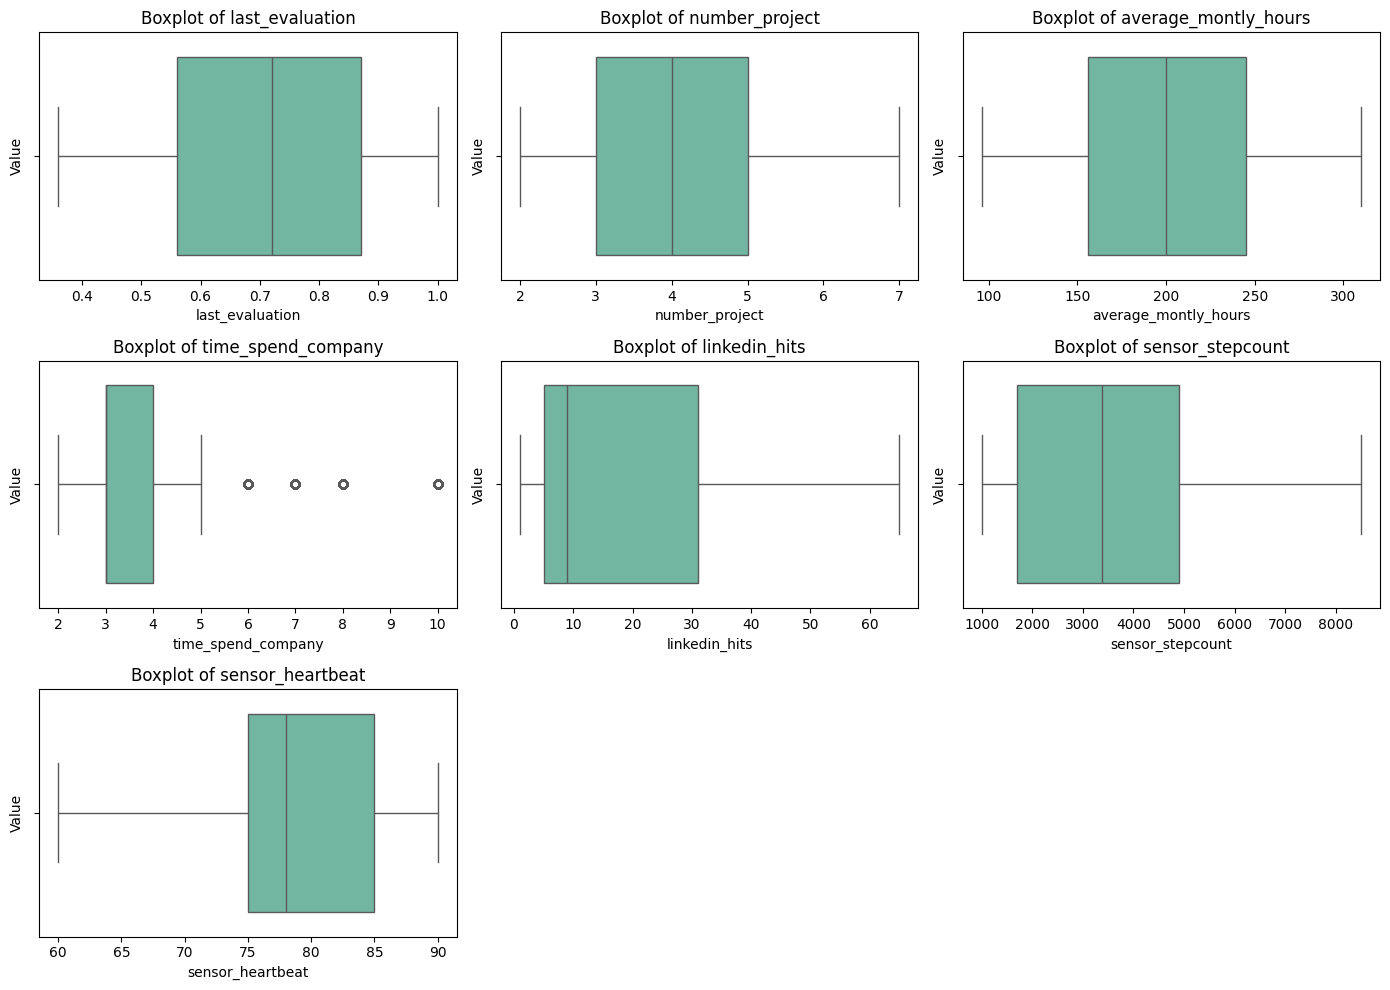

In [17]:
# detecting outliers with numerical columns only

numerical_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'time_spend_company', 'linkedin_hits', 'sensor_stepcount',
                     'sensor_heartbeat']

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=data[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [18]:
# time_spend_company is the only numeric variable with outliers therefore we will use the Robust Scaler.

rb_scaler = RobustScaler()
data['time_spend_company'] = rb_scaler.fit_transform(data[['time_spend_company']])


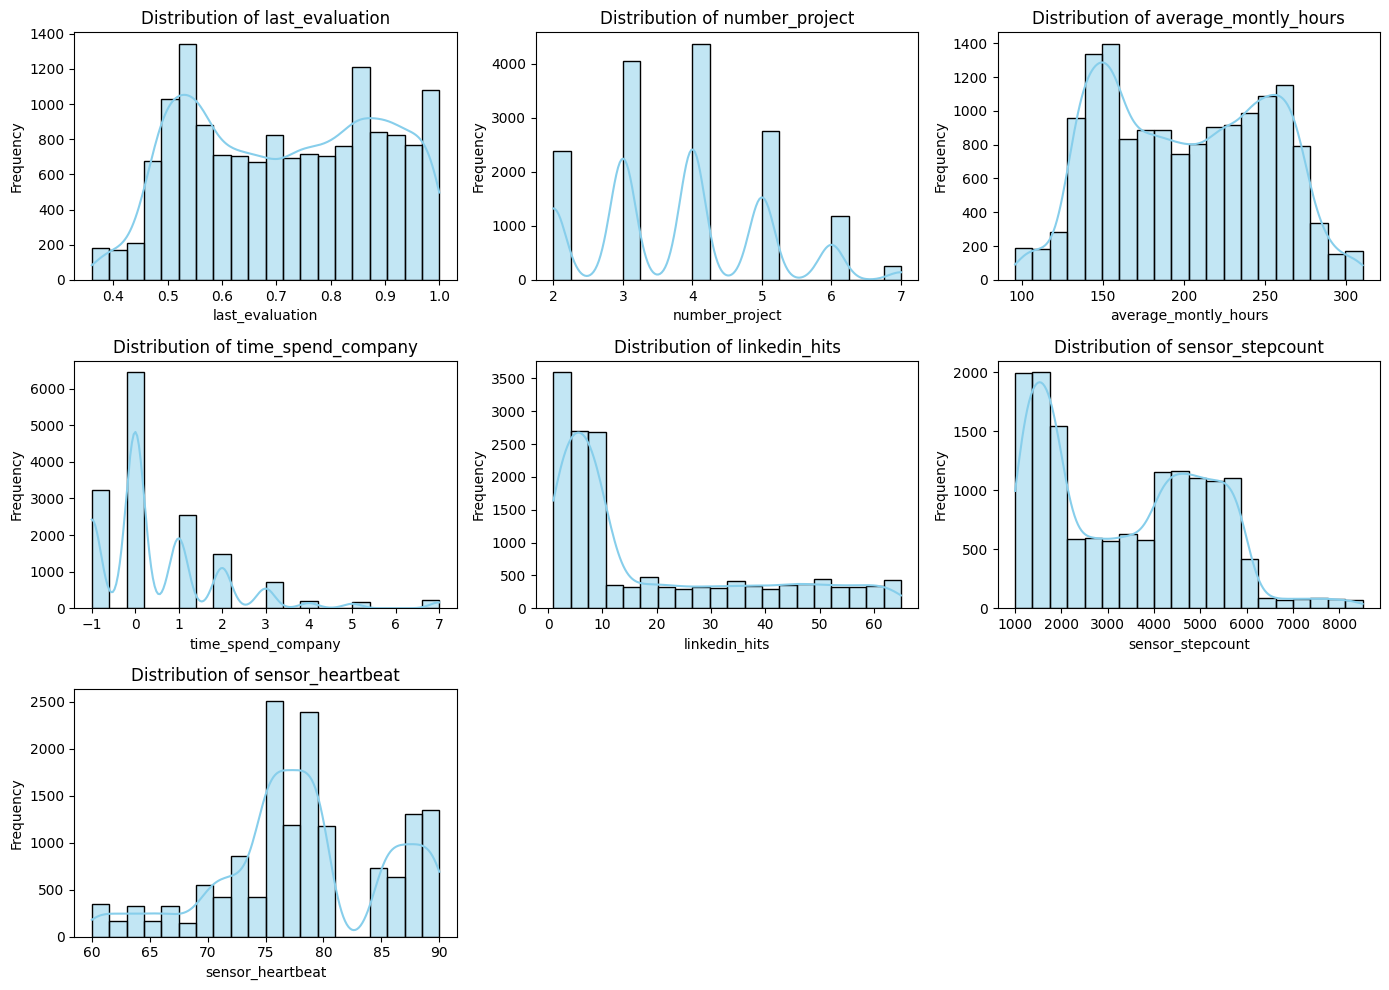

In [19]:
# plot the distributions of the numerical features to determine which scalers to use
# none of the plots seems to be normally distributed so the MinMaxScaling is chosen

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [20]:
# for all other numerical variables, use the minmaxscaler

minmaxscaler_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'linkedin_hits', 'sensor_stepcount', 'sensor_heartbeat']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
data[minmaxscaler_columns] = scaler.fit_transform(data[minmaxscaler_columns])


# Categorical Features ONLY Feature Engineering

In [21]:
# ordinal encoding for salary

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(data[['salary']])
data['encoded_salary'] = ordinal_encoder.transform(data[['salary']]) # 1 = low, 2 = medium, 3 = high
data.drop(columns = ['salary'], inplace = True)


In [22]:
# OneHotEncoding for department, geo and role

ohe_columns = ['department', 'geo', 'role']

ohe = OneHotEncoder(sparse_output = False)

ohe_data = ohe.fit_transform(data[ohe_columns])

ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))

encoded_data = pd.concat([data, ohe_df], axis=1)

encoded_data.drop(columns = ['department', 'geo', 'role'], inplace = True)


# Variable allocation

In [23]:
# define x and y variables

X = encoded_data.drop(columns = 'left_company')

y = encoded_data['left_company']


# Feature correlation

<Axes: >

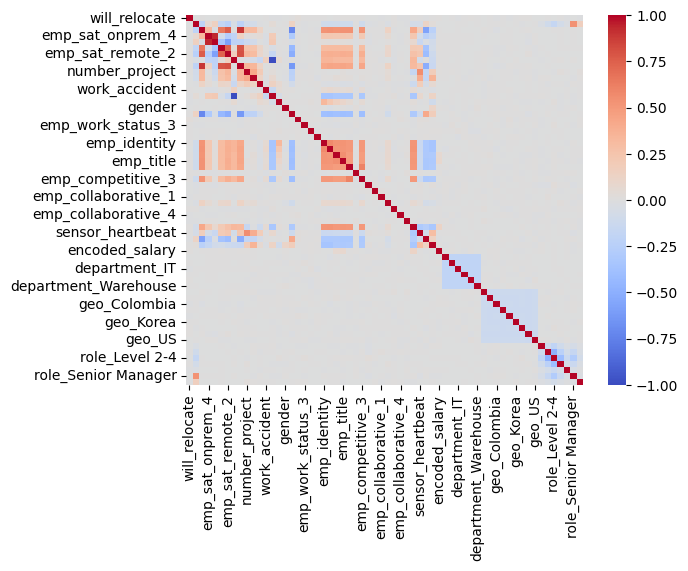

In [24]:
# Correlation Matrix
sns.heatmap(encoded_data.corr(), cmap='coolwarm')


In [25]:
# visualise the correlation

# Calculate the correlation matrix
corr_matrix = encoded_data.corr()

# Create an empty list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, col in enumerate(corr_matrix.columns):
    for j, index in enumerate(corr_matrix.index):
        if i < j:  # Only store pairs once to avoid duplicates and self-correlation
            correlation_pairs.append([index, col, corr_matrix.iloc[j, i]])

# Convert the list to a DataFrame
corr_df = pd.DataFrame(correlation_pairs, columns=['feature_1', 'feature_2', 'correlation'])

corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation

corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

corr_df.head()


,feature_1,feature_2,correlation
180,emp_sat_onprem_5,emp_sat_onprem_4,0.930062
126,last_evaluation,percent_remote,0.897223
352,last_evaluation,emp_sat_remote_2,0.805922
297,last_evaluation,emp_sat_remote_1,0.796292
124,emp_sat_remote_2,percent_remote,0.762327


In [26]:
# remove highly correlated features >= 0.7 or <= -0.7

correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]

X.drop(columns = ['emp_sat_onprem_4', 'percent_remote', 'emp_sat_remote_2', 'emp_sat_remote_1', 'emp_engagement_1','critical','emp_competitive_1','emp_competitive_2','emp_competitive_3','emp_competitive_4','emp_competitive_5','emp_collaborative_1','emp_collaborative_2','emp_collaborative_3','emp_collaborative_4','emp_collaborative_5'], inplace = True)


In [27]:
X.isnull().sum().sort_values(ascending=False)

will_relocate                 0
department_Finance            0
department_IT                 0
department_Operations         0
department_Sales              0
department_Warehouse          0
geo_Australia                 0
geo_China                     0
geo_Colombia                  0
geo_France                    0
geo_Japan                     0
geo_Korea                     0
geo_Turkey                    0
geo_UK                        0
geo_US                        0
role_Director                 0
role_Level 1                  0
role_Level 2-4                0
role_Manager                  0
role_Senior Director          0
role_Senior Manager           0
department_Human Resources    0
encoded_salary                0
emp_sat_onprem_5              0
leave                         0
last_evaluation               0
number_project                0
average_montly_hours          0
time_spend_company            0
work_accident                 0
promotion_last_5years         0
gender  

## Random Forrest


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# Evaluate the model
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       0.99      0.98      0.99       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2280    6]
 [  12  702]]


## Evaluating the model


In [31]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       0.99      0.98      0.99       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2280    6]
 [  12  702]]


## Feature importance


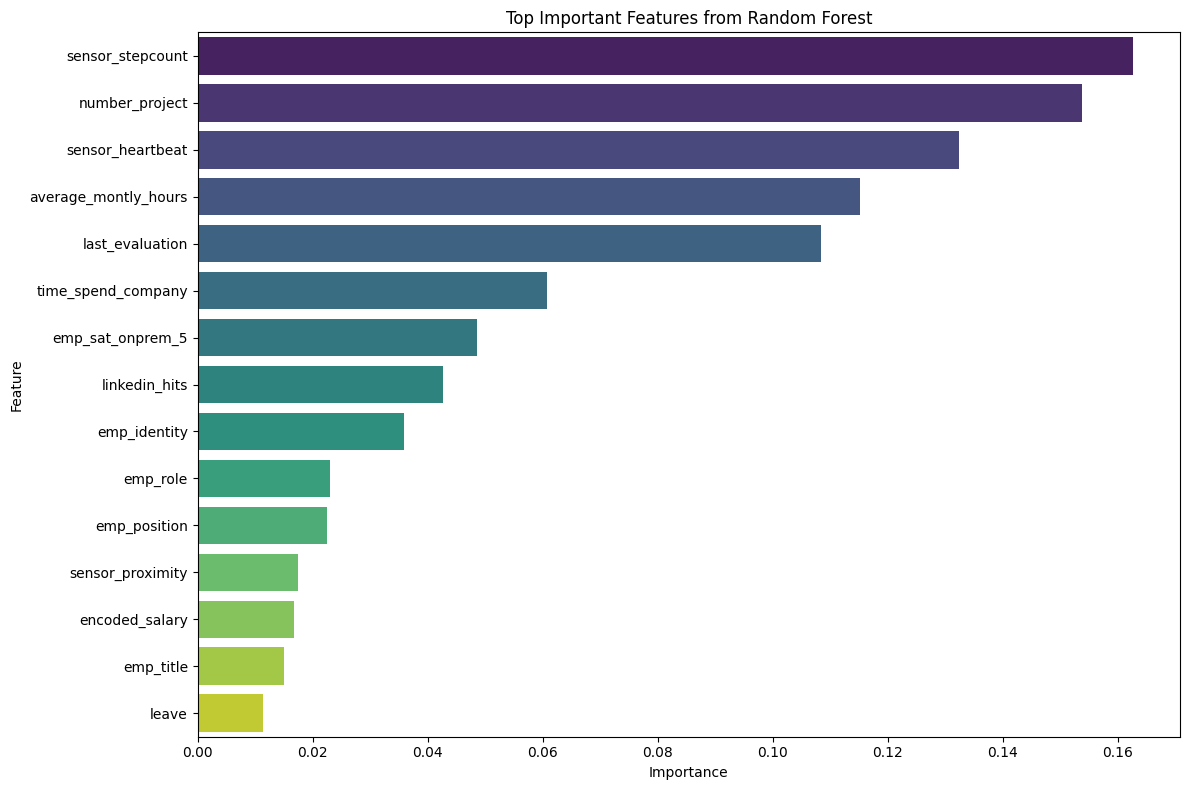

In [32]:
feature_names = X.columns.tolist()

rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
})

# Filter features with importance greater than 0.01
rf_feature_importance = rf_feature_importance[rf_feature_importance['Importance'] > 0.01]

# Plotting feature importance using Seaborn for better visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Top Important Features from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Feature Selection

In [33]:
selected_features = ['last_evaluation', 'number_project', 'average_montly_hours', 'sensor_stepcount','sensor_heartbeat'] #'time_spend_company'
X = X[selected_features]
X_scaled=X
X_scaled

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat
0,0.0,0.2,0.336449,0.112133,0.033333
1,0.0,0.6,0.294393,0.132000,1.000000
2,0.0,0.0,0.869159,0.292400,0.666667
3,0.0,0.4,0.850467,0.299733,0.566667
4,0.0,0.8,0.747664,0.286533,0.666667
...,...,...,...,...,...
14994,1.0,0.4,0.728972,0.071733,0.933333
14995,1.0,0.4,0.635514,0.032933,0.966667
14996,1.0,0.6,0.682243,0.020667,0.933333
14997,1.0,0.6,0.593458,0.028000,0.866667


# Unsupervised Learning

In [34]:
# Create a copy of X to store the clusters and add company left
X_cluster=X
X_cluster['left_company']=data['left_company']
X_cluster

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company
0,0.0,0.2,0.336449,0.112133,0.033333,0
1,0.0,0.6,0.294393,0.132000,1.000000,0
2,0.0,0.0,0.869159,0.292400,0.666667,0
3,0.0,0.4,0.850467,0.299733,0.566667,0
4,0.0,0.8,0.747664,0.286533,0.666667,0
...,...,...,...,...,...,...
14994,1.0,0.4,0.728972,0.071733,0.933333,1
14995,1.0,0.4,0.635514,0.032933,0.966667,1
14996,1.0,0.6,0.682243,0.020667,0.933333,1
14997,1.0,0.6,0.593458,0.028000,0.866667,1


## K-Means (Emily)

### PCA 

In [35]:

# Add the cluster labels to the original data

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

### Five clusters

Cluster Centers:
 [[-0.23937494 -0.02321102]
 [ 0.87986124  0.42602738]
 [ 0.62197726 -0.7499544 ]
 [-0.23485394  0.23501882]
 [-0.26004729 -0.45574826]]


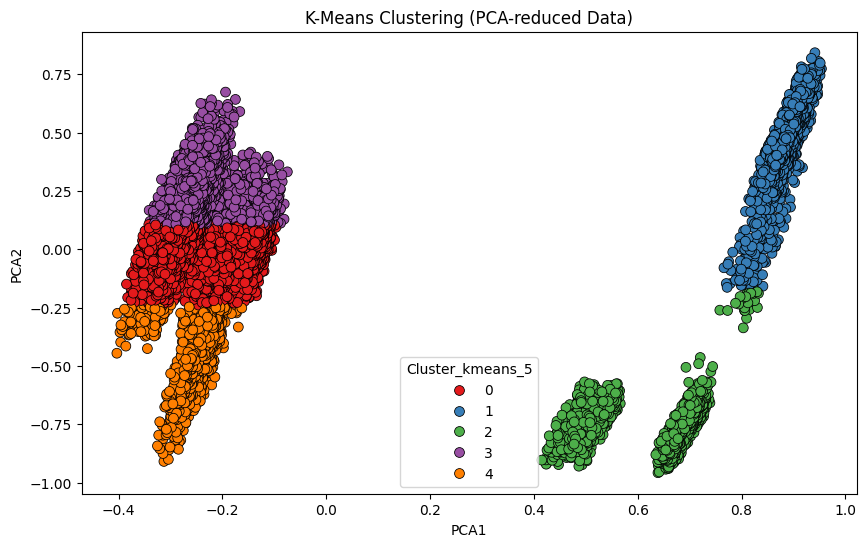

In [36]:


kmeans_5 = KMeans(n_clusters=5, random_state=42)
data['Cluster_kmeans_5'] = kmeans_5.fit_predict(X_pca)
data['Cluster_kmeans_5'] = kmeans_5.labels_
X_cluster['Cluster_kmeans_5']=data['Cluster_kmeans_5']
# Print cluster centers
print("Cluster Centers:\n", kmeans_5.cluster_centers_)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster_kmeans_5'] = data['Cluster_kmeans_5']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_5', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_5')
plt.show()


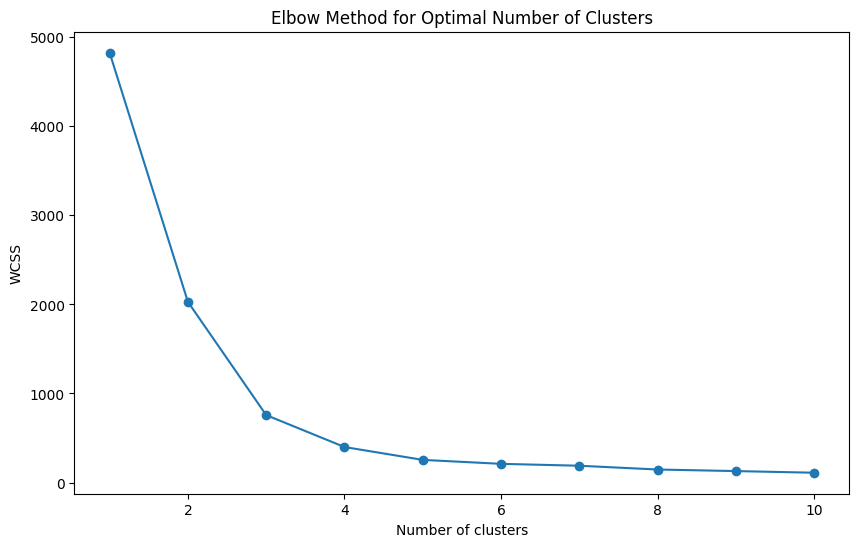

In [37]:
# Elbow method to determine the optimal number of clusters
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [38]:
# # Print cluster centers
# cluster_centers_kmeans_5 = pd.DataFrame(kmeans_5.cluster_centers_, columns=X.columns)
# print("Cluster Centers:\n", cluster_centers_kmeans_5)

In [39]:
# Analyze the number of points in each cluster
cluster_distribution = data['Cluster_kmeans_5'].value_counts().sort_index()
print("Cluster Distribution:\n", cluster_distribution)

Cluster Distribution:
 Cluster_kmeans_5
0    5840
1    2022
2    1549
3    4300
4    1288
Name: count, dtype: int64


Comparison Table:
 left_company        0    1
Cluster_kmeans_5          
0                 1.0  0.0
1                 0.0  1.0
2                 0.0  1.0
3                 1.0  0.0
4                 1.0  0.0


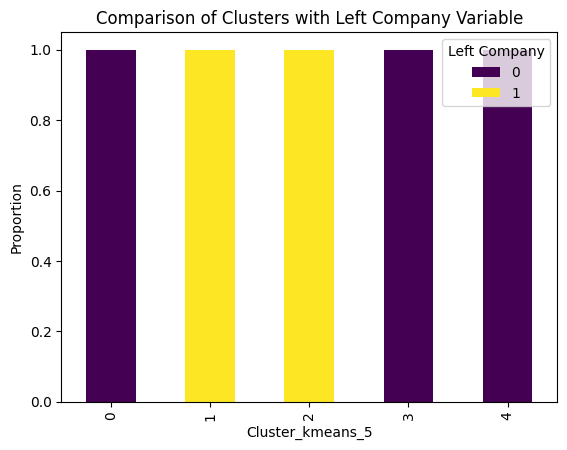

In [40]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_5', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_5'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_5')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [41]:
X_cluster.groupby('Cluster_kmeans_5').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company
Cluster_kmeans_5,,,,,,
0,0.499438,0.312945,0.450082,0.352649,0.626553,0.0
1,0.806333,0.653017,0.745246,0.066641,0.916452,1.0
2,0.237411,0.003099,0.227473,0.331161,0.263460,1.0
3,0.699669,0.484279,0.590299,0.451500,0.625566,0.0
4,0.327737,0.134783,0.261523,0.127663,0.289467,0.0


### Four clusters

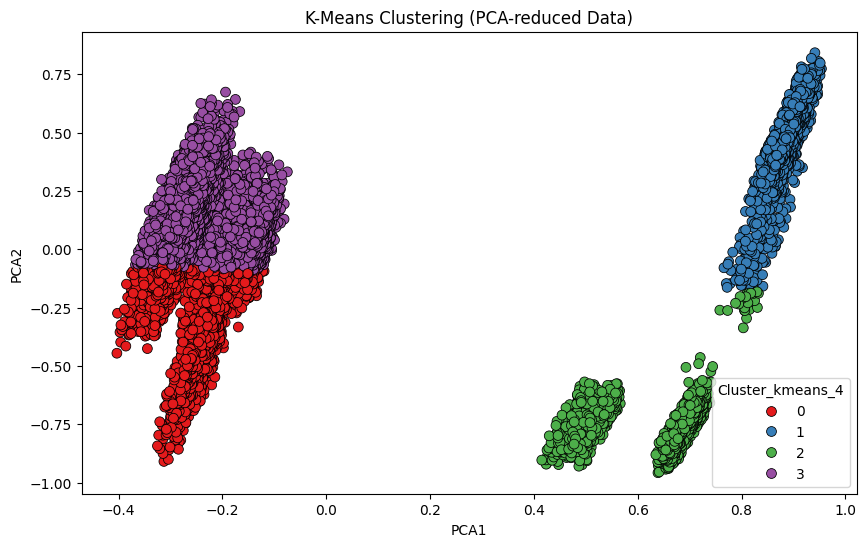

In [42]:


# # Standardize the selected features
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_selected)

# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_4 = KMeans(n_clusters=4, random_state=42)
data['Cluster_kmeans_4'] = kmeans_4.fit_predict(X_pca)
X_cluster['Cluster_kmeans_4']=data['Cluster_kmeans_4']

pca_df['Cluster_kmeans_4'] = data['Cluster_kmeans_4']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_4', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_4')
plt.show()

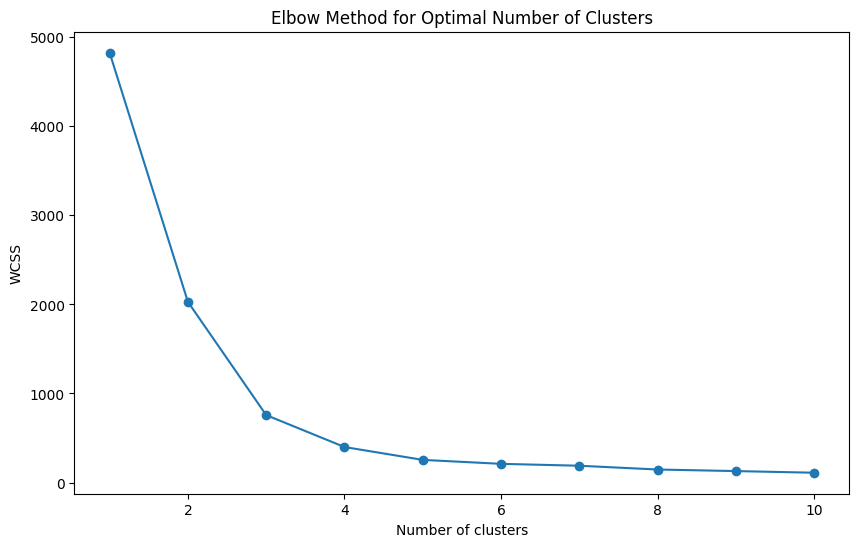

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to determine the optimal number of clusters
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Comparison Table:
 left_company        0    1
Cluster_kmeans_4          
0                 1.0  0.0
1                 0.0  1.0
2                 0.0  1.0
3                 1.0  0.0


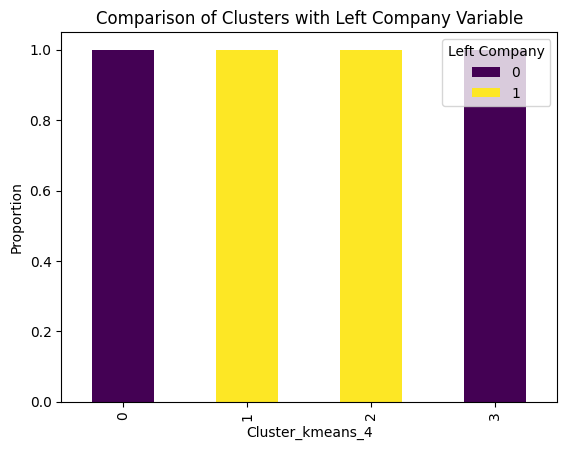

In [44]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_4', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_4'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_4')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [45]:
X_cluster.groupby('Cluster_kmeans_4').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5
Cluster_kmeans_4,,,,,,,
0,0.389220,0.178647,0.343869,0.251160,0.440926,0.0,1.883729
1,0.806333,0.653017,0.745246,0.066641,0.916452,1.0,1.000000
2,0.237411,0.003099,0.227473,0.331161,0.263460,1.0,2.000000
3,0.607720,0.413551,0.524920,0.400141,0.634522,0.0,1.483953


### Three clusters

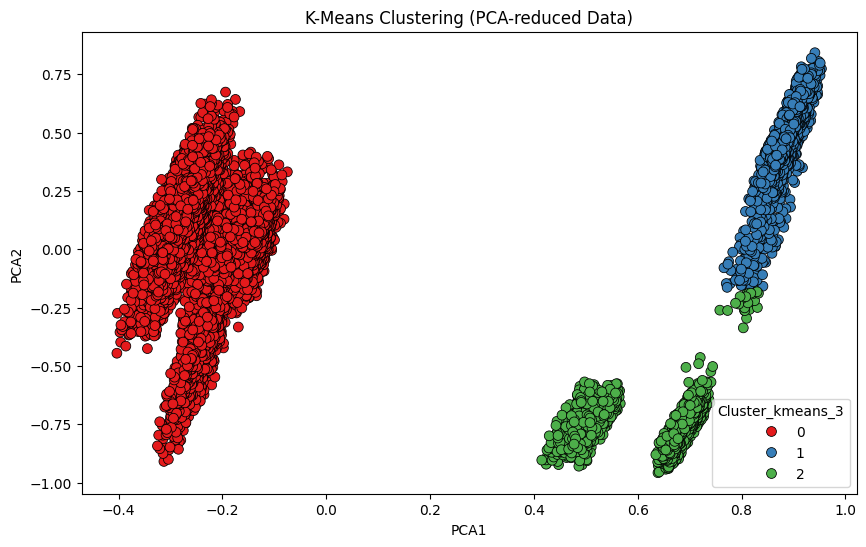

In [46]:
# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_3 = KMeans(n_clusters=3, random_state=42)
data['Cluster_kmeans_3'] = kmeans_3.fit_predict(X_pca)
X_cluster['Cluster_kmeans_3']=data['Cluster_kmeans_3']

pca_df['Cluster_kmeans_3'] = data['Cluster_kmeans_3']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_3', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_3')
plt.show()

Comparison Table:
 left_company        0    1
Cluster_kmeans_3          
0                 1.0  0.0
1                 0.0  1.0
2                 0.0  1.0


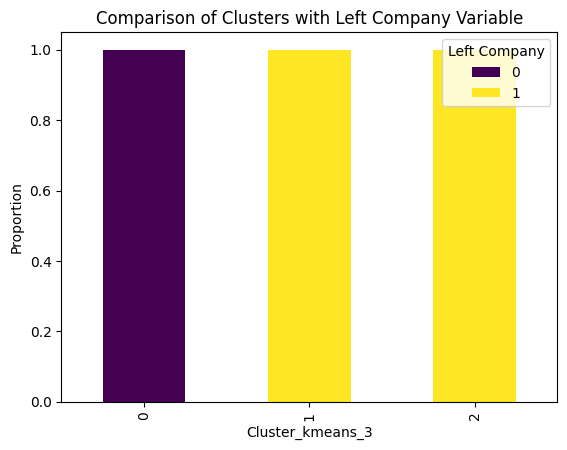

In [47]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_3', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_3'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_3')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [48]:
X_cluster.groupby('Cluster_kmeans_3').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4
Cluster_kmeans_3,,,,,,,,
0,0.555427,0.357333,0.481590,0.364486,0.588190,0.0,1.579629,2.282027
1,0.806333,0.653017,0.745246,0.066641,0.916452,1.0,1.000000,1.000000
2,0.237411,0.003099,0.227473,0.331161,0.263460,1.0,2.000000,2.000000


### Two custers

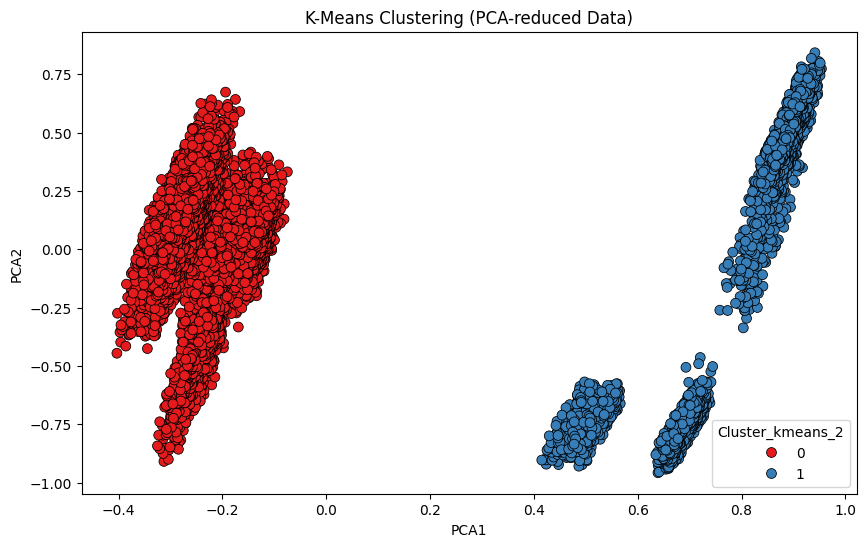

In [49]:
# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_2 = KMeans(n_clusters=2, random_state=42)
data['Cluster_kmeans_2'] = kmeans_2.fit_predict(X_pca)
X_cluster['Cluster_kmeans_2']=data['Cluster_kmeans_2']
pca_df['Cluster_kmeans_2'] = data['Cluster_kmeans_2']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_2', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_2')
plt.show()

In [50]:
X_cluster.groupby('Cluster_kmeans_2').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3
Cluster_kmeans_2,,,,,,,,,
0,0.555427,0.357333,0.481590,0.364486,0.588190,0.0,1.579629,2.282027,0.000000
1,0.559551,0.371101,0.520651,0.181382,0.633203,1.0,1.433772,1.433772,1.433772


Comparison Table:
 left_company        0    1
Cluster_kmeans_2          
0                 1.0  0.0
1                 0.0  1.0


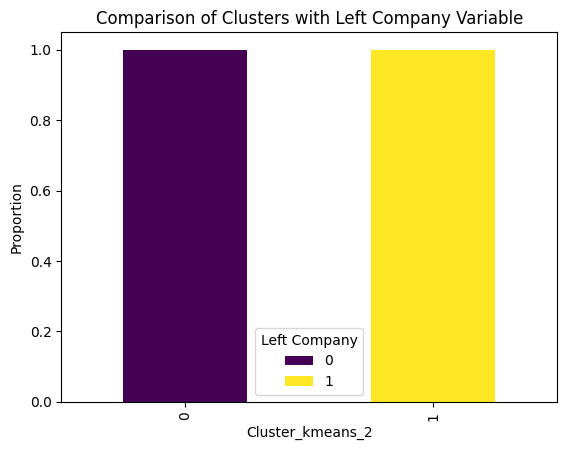

In [51]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_2', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_2'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_2')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Six clusters

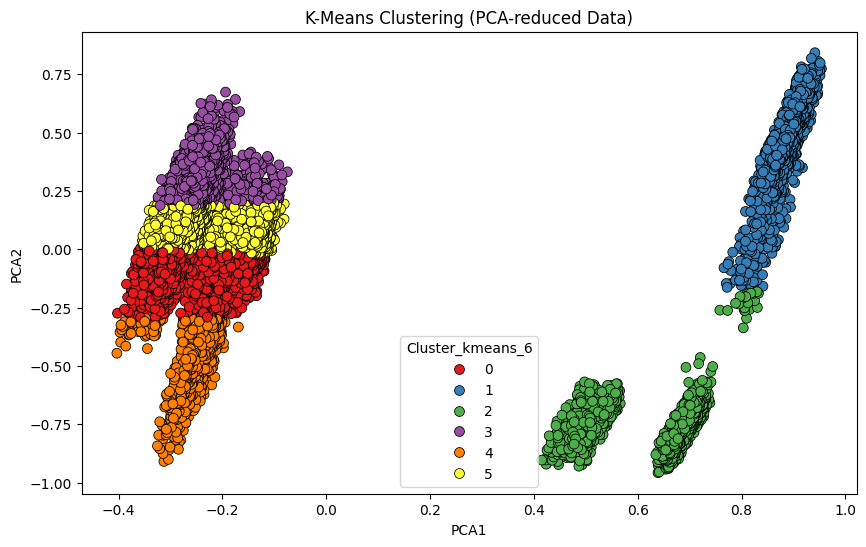

In [52]:
# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_6 = KMeans(n_clusters=6, random_state=42)
data['Cluster_kmeans_6'] = kmeans_6.fit_predict(X_pca)
X_cluster['Cluster_kmeans_6']=data['Cluster_kmeans_6']
pca_df['Cluster_kmeans_6'] = data['Cluster_kmeans_6']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_6', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_6')
plt.show()

In [53]:
X_cluster.groupby('Cluster_kmeans_6').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2
Cluster_kmeans_6,,,,,,,,,,
0,0.468559,0.249546,0.426836,0.359170,0.588739,0.0,0.257742,1.448858,0.0,0.0
1,0.806333,0.653017,0.745246,0.066641,0.916452,1.0,1.000000,1.000000,1.0,1.0
2,0.237411,0.003099,0.227473,0.331161,0.263460,1.0,2.000000,2.000000,2.0,1.0
3,0.762569,0.514737,0.633348,0.489508,0.613354,0.0,3.000000,3.000000,0.0,0.0
4,0.311229,0.137523,0.242973,0.095579,0.247505,0.0,4.000000,0.000000,0.0,0.0
5,0.559252,0.397185,0.492229,0.362651,0.653840,0.0,1.149199,3.000000,0.0,0.0


Comparison Table:
 left_company        0    1
Cluster_kmeans_6          
0                 1.0  0.0
1                 0.0  1.0
2                 0.0  1.0
3                 1.0  0.0
4                 1.0  0.0
5                 1.0  0.0


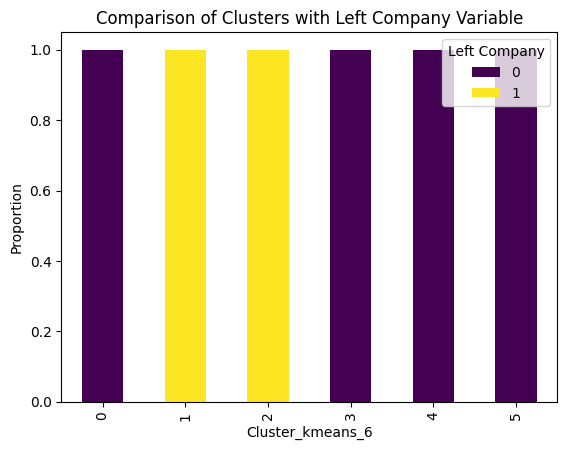

In [54]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_6', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_6'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_6')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Comparing the number of clusters

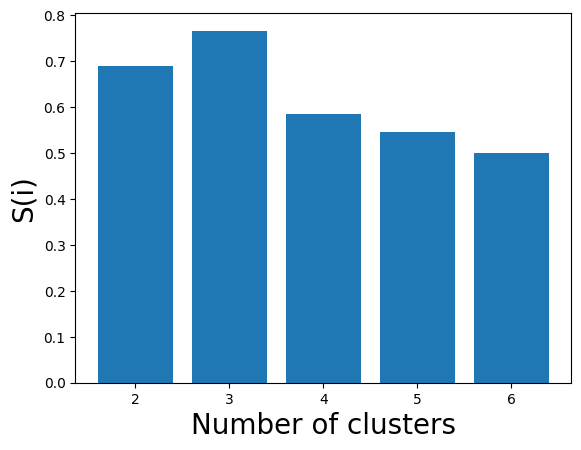

In [55]:
# Could be used here as well
#Using Silhouette Scores to identify the right number of clusters
k = [2,3,4,5,6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
        silhouette_score(X_pca, kmeans_2.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, kmeans_3.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, kmeans_4.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, kmeans_5.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, kmeans_6.fit_predict(X_pca))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 

## AgglomerativeClustering

### PCA

In [56]:
# # PCA

# pca = PCA(n_components = 2) 
# X_principal = pca.fit_transform(X) 
# X_principal = pd.DataFrame(X_principal) 
# X_principal.columns = ['PCA1', 'PCA2'] 


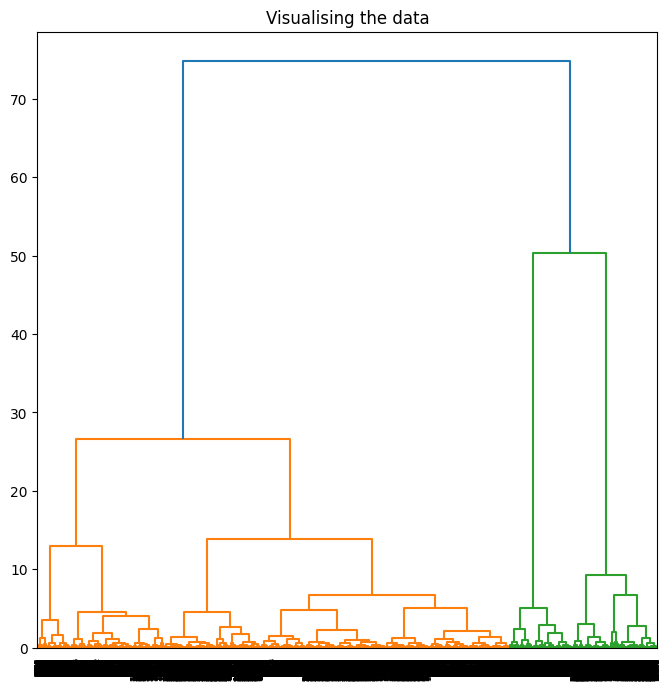

In [57]:
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(X_pca, method ='ward'))) 

### Two Clusters

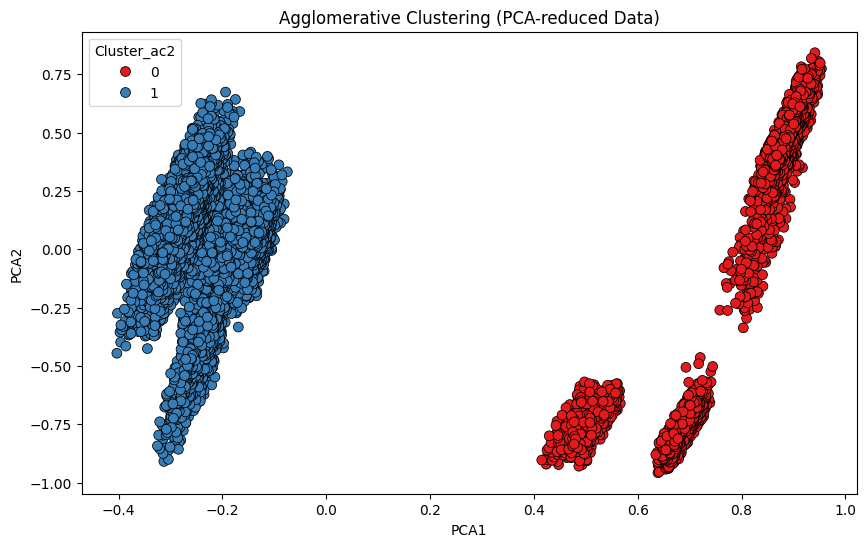

In [58]:
#Agglomerative Clustering / Ward hierarchical clustering
ac2 = AgglomerativeClustering(n_clusters = 2) 
# plt.figure(figsize =(6, 6)) 
# plt.scatter(X_principal['PCA1'], X_principal['PCA2'],  
#            c = ac2.fit_predict(X_principal), cmap ='rainbow') 
# plt.show()

data['Cluster_ac2'] = ac2.fit_predict(X_pca)
ac2_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
ac2_df['Cluster_ac2'] = data['Cluster_ac2']
X_cluster['Cluster_ac2']=data['Cluster_ac2']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac2_df, x='PCA1', y='PCA2', hue='Cluster_ac2', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac2')
plt.show()


In [59]:
cluster_distribution = data['Cluster_ac2'].value_counts().sort_index()
cluster_distribution

Cluster_ac2
0     3571
1    11428
Name: count, dtype: int64

Comparison Table:
 left_company    0    1
Cluster_ac2           
0             0.0  1.0
1             1.0  0.0


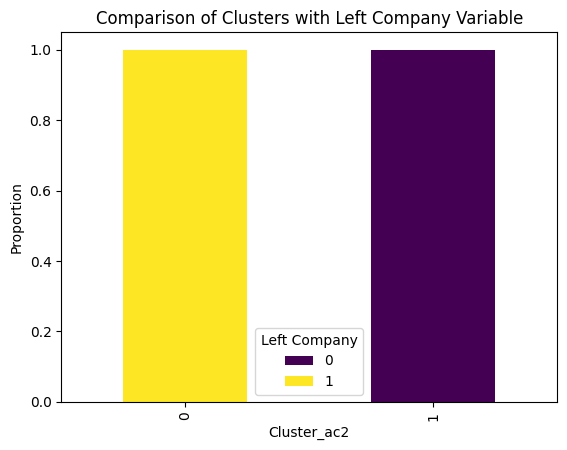

In [60]:
comparison_df = data[['Cluster_ac2', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac2'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac2')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [61]:
X_cluster.groupby('Cluster_ac2').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,Cluster_kmeans_6
Cluster_ac2,,,,,,,,,,,
0,0.559551,0.371101,0.520651,0.181382,0.633203,1.0,1.433772,1.433772,1.433772,1.0,1.433772
1,0.555427,0.357333,0.481590,0.364486,0.588190,0.0,1.579629,2.282027,0.000000,0.0,3.063616


### Three Clusters

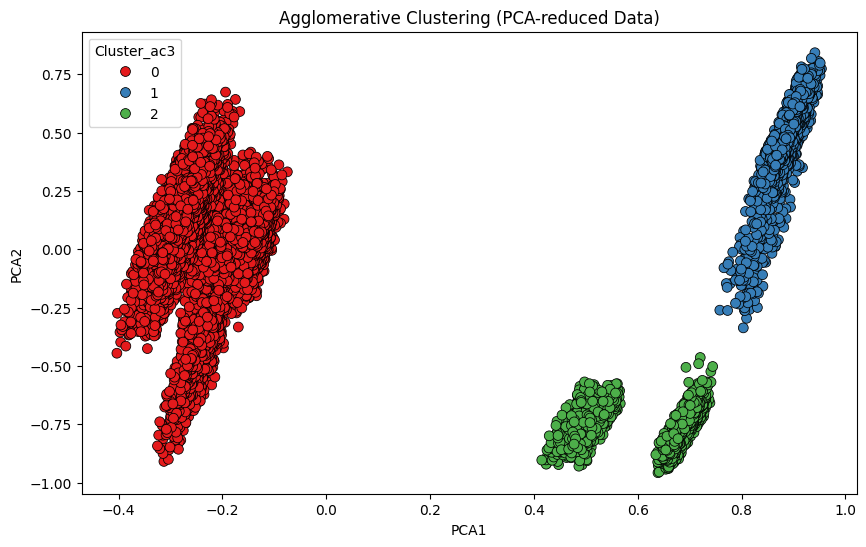

In [62]:
ac3 = AgglomerativeClustering(n_clusters = 3) 
data['Cluster_ac3'] = ac3.fit_predict(X_pca)
ac3_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
ac3_df['Cluster_ac3'] = data['Cluster_ac3']
X_cluster['Cluster_ac3']=data['Cluster_ac3']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac3_df, x='PCA1', y='PCA2', hue='Cluster_ac3', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac3')
plt.show()


In [63]:
cluster_distribution = data['Cluster_ac3'].value_counts().sort_index()
cluster_distribution

Cluster_ac3
0    11428
1     2047
2     1524
Name: count, dtype: int64

Comparison Table:
 left_company    0    1
Cluster_ac3           
0             1.0  0.0
1             0.0  1.0
2             0.0  1.0


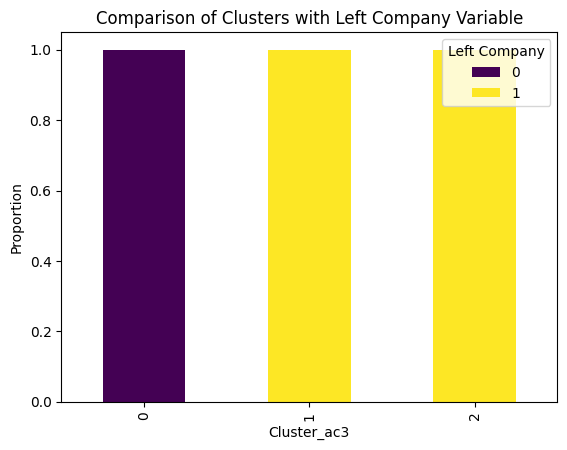

In [64]:
comparison_df = data[['Cluster_ac3', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac3'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac3')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [65]:
X_cluster.groupby('Cluster_ac3').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,Cluster_kmeans_6,Cluster_ac2
Cluster_ac3,,,,,,,,,,,,
0,0.555427,0.357333,0.481590,0.364486,0.588190,0.0,1.579629,2.282027,0.000000,0.0,3.063616,1.0
1,0.800340,0.646702,0.742014,0.066422,0.916186,1.0,1.012213,1.012213,1.012213,1.0,1.012213,0.0
2,0.236128,0.000919,0.223321,0.335794,0.253106,1.0,2.000000,2.000000,2.000000,1.0,2.000000,0.0


### Four clusters

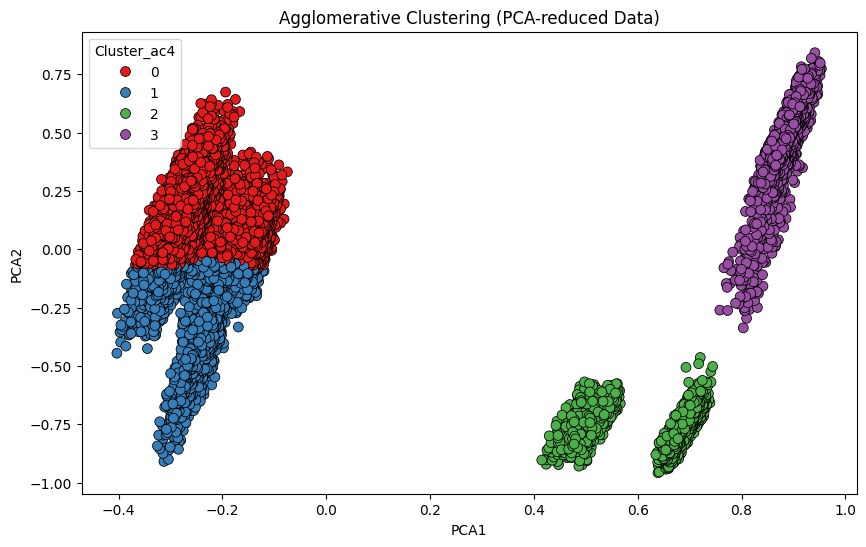

In [66]:
ac4 = AgglomerativeClustering(n_clusters = 4) 
data['Cluster_ac4'] = ac4.fit_predict(X_pca)
ac4_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
ac4_df['Cluster_ac4'] = data['Cluster_ac4']
X_cluster['Cluster_ac4']=data['Cluster_ac4']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac4_df, x='PCA1', y='PCA2', hue='Cluster_ac4', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac4')
plt.show()

In [67]:
cluster_distribution = data['Cluster_ac4'].value_counts().sort_index()
cluster_distribution

Cluster_ac4
0    8345
1    3083
2    1524
3    2047
Name: count, dtype: int64

Comparison Table:
 left_company    0    1
Cluster_ac4           
0             1.0  0.0
1             1.0  0.0
2             0.0  1.0
3             0.0  1.0


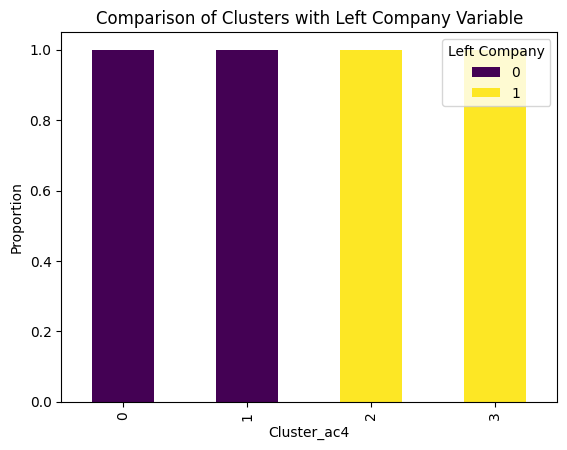

In [68]:
comparison_df = data[['Cluster_ac4', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac4'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac4')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [69]:
X_cluster.groupby('Cluster_ac4').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,Cluster_kmeans_6,Cluster_ac2,Cluster_ac3
Cluster_ac4,,,,,,,,,,,,,
0,0.619516,0.419437,0.522478,0.405474,0.633805,0.0,1.545836,2.993889,0.000000,0.0,3.676812,1.0,0.0
1,0.381953,0.189231,0.370914,0.253541,0.464721,0.0,1.671100,0.355174,0.000000,0.0,1.403827,1.0,0.0
2,0.236128,0.000919,0.223321,0.335794,0.253106,1.0,2.000000,2.000000,2.000000,1.0,2.000000,0.0,2.0
3,0.800340,0.646702,0.742014,0.066422,0.916186,1.0,1.012213,1.012213,1.012213,1.0,1.012213,0.0,1.0


### Five clusters

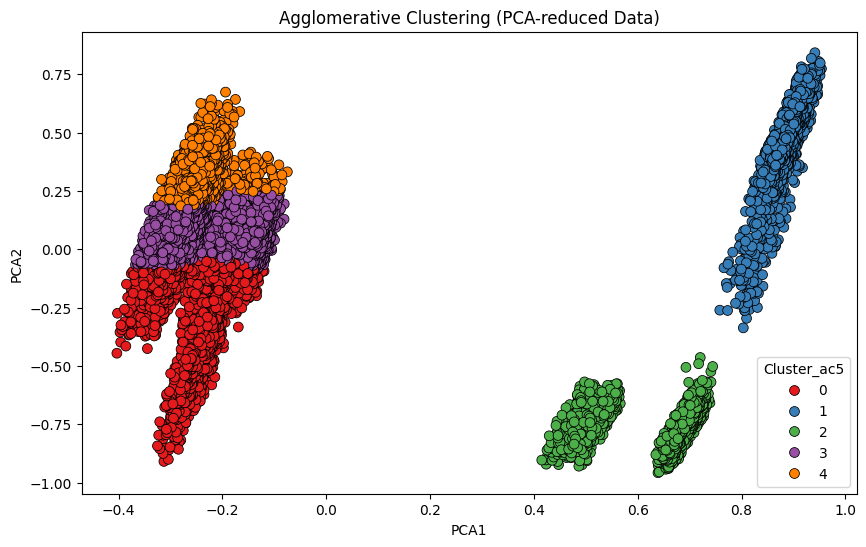

In [70]:
ac5 = AgglomerativeClustering(n_clusters = 5) 
data['Cluster_ac5'] = ac5.fit_predict(X_pca)
ac5_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
ac5_df['Cluster_ac5'] = data['Cluster_ac5']
X_cluster['Cluster_ac5']=data['Cluster_ac5']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac5_df, x='PCA1', y='PCA2', hue='Cluster_ac5', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac5')
plt.show()

In [71]:
cluster_distribution = data['Cluster_ac5'].value_counts().sort_index()
cluster_distribution

Cluster_ac5
0    3083
1    2047
2    1524
3    6016
4    2329
Name: count, dtype: int64

Comparison Table:
 left_company    0    1
Cluster_ac5           
0             1.0  0.0
1             0.0  1.0
2             0.0  1.0
3             1.0  0.0
4             1.0  0.0


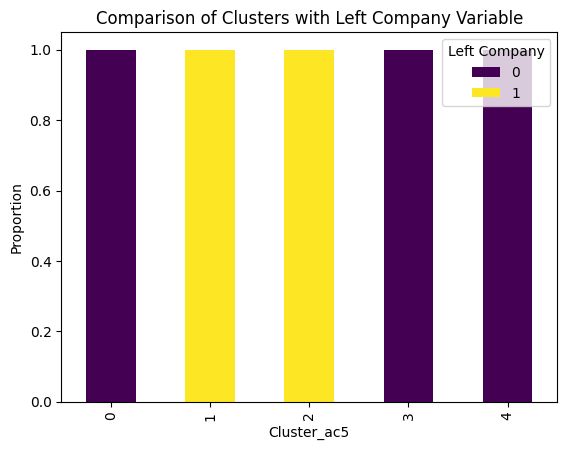

In [72]:
comparison_df = data[['Cluster_ac5', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac5'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac5')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [73]:
X_cluster.groupby('Cluster_ac5').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,Cluster_kmeans_6,Cluster_ac2,Cluster_ac3,Cluster_ac4
Cluster_ac5,,,,,,,,,,,,,,
0,0.381953,0.189231,0.370914,0.253541,0.464721,0.0,1.671100,0.355174,0.000000,0.0,1.403827,1.0,0.0,1.0
1,0.800340,0.646702,0.742014,0.066422,0.916186,1.0,1.012213,1.012213,1.012213,1.0,1.012213,0.0,1.0,3.0
2,0.236128,0.000919,0.223321,0.335794,0.253106,1.0,2.000000,2.000000,2.000000,1.0,2.000000,0.0,2.0,2.0
3,0.553186,0.386070,0.477389,0.365086,0.645922,0.0,0.982879,2.991523,0.000000,0.0,3.933843,1.0,0.0,0.0
4,0.790850,0.505625,0.638947,0.509799,0.602505,0.0,3.000000,3.000000,0.000000,0.0,3.012881,1.0,0.0,0.0


### Six clusters

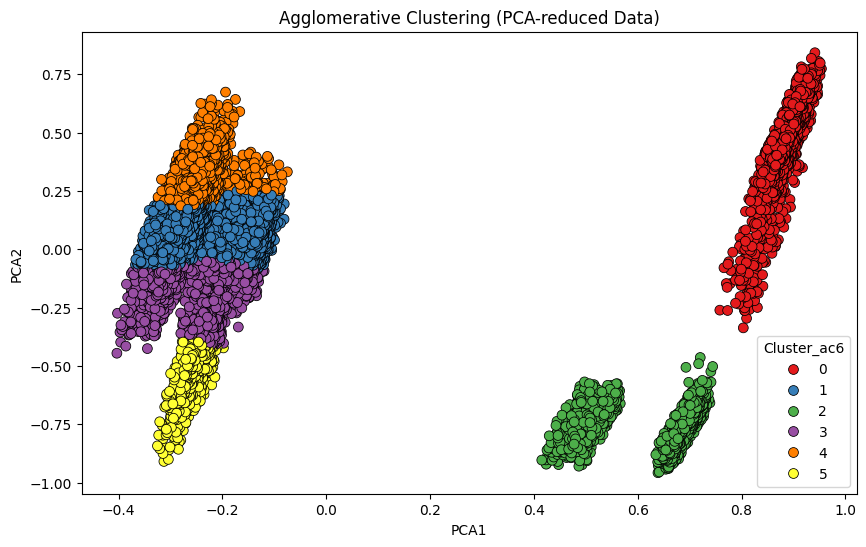

In [74]:
ac6 = AgglomerativeClustering(n_clusters = 6) 
data['Cluster_ac6'] = ac6.fit_predict(X_pca)
ac6_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
ac6_df['Cluster_ac6'] = data['Cluster_ac6']
X_cluster['Cluster_ac6']=data['Cluster_ac6']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac6_df, x='PCA1', y='PCA2', hue='Cluster_ac6', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac6')
plt.show()

In [75]:
cluster_distribution = data['Cluster_ac6'].value_counts().sort_index()
cluster_distribution

Cluster_ac6
0    2047
1    6016
2    1524
3    2283
4    2329
5     800
Name: count, dtype: int64

Comparison Table:
 left_company    0    1
Cluster_ac6           
0             0.0  1.0
1             1.0  0.0
2             0.0  1.0
3             1.0  0.0
4             1.0  0.0
5             1.0  0.0


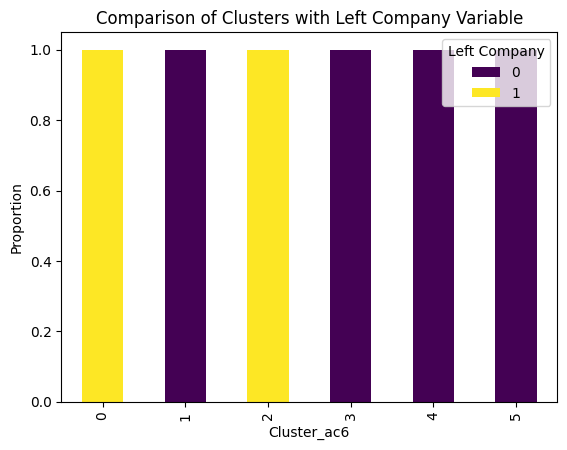

In [76]:
comparison_df = data[['Cluster_ac6', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac6'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac6')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [77]:
X_cluster.groupby('Cluster_ac6').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,Cluster_kmeans_6,Cluster_ac2,Cluster_ac3,Cluster_ac4,Cluster_ac5
Cluster_ac6,,,,,,,,,,,,,,,
0,0.800340,0.646702,0.742014,0.066422,0.916186,1.0,1.012213,1.012213,1.012213,1.0,1.012213,0.0,1.0,3.0,1.0
1,0.553186,0.386070,0.477389,0.365086,0.645922,0.0,0.982879,2.991523,0.000000,0.0,3.933843,1.0,0.0,0.0,3.0
2,0.236128,0.000919,0.223321,0.335794,0.253106,1.0,2.000000,2.000000,2.000000,1.0,2.000000,0.0,2.0,2.0,2.0
3,0.417378,0.207534,0.421560,0.318658,0.560812,0.0,0.855015,0.479632,0.000000,0.0,0.494087,1.0,0.0,1.0,0.0
4,0.790850,0.505625,0.638947,0.509799,0.602505,0.0,3.000000,3.000000,0.000000,0.0,3.012881,1.0,0.0,0.0,4.0
5,0.280859,0.137000,0.226384,0.067715,0.190500,0.0,4.000000,0.000000,0.000000,0.0,4.000000,1.0,0.0,1.0,0.0


## Comparing number of clusters

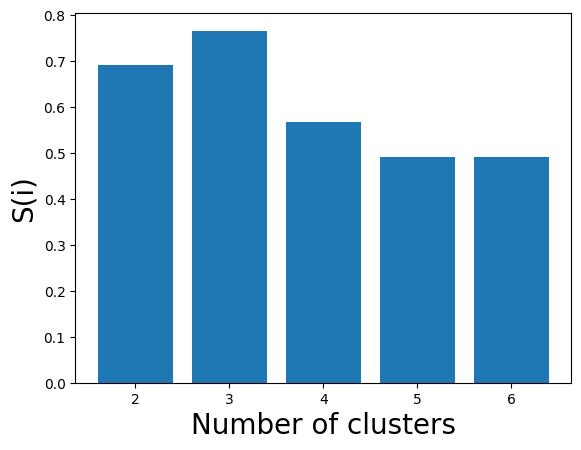

In [78]:
# Using Silhouette Scores to identify the right number of clusters
k = [2, 3, 4, 5, 6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
        silhouette_score(X_pca, ac2.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, ac3.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, ac4.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, ac5.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, ac6.fit_predict(X_pca))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 

## DBSCAN Clustering

### k-distance graph

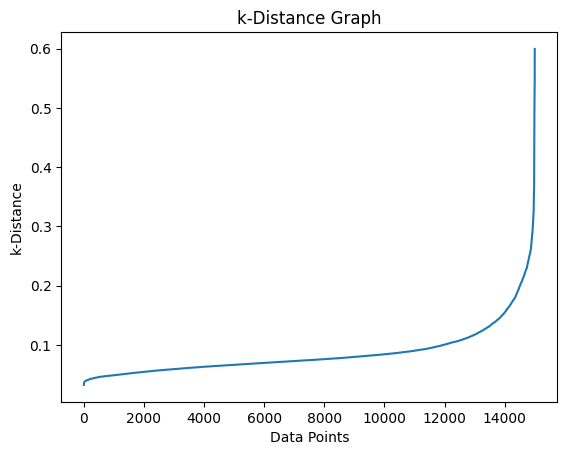

In [79]:
# estimating eps value 
k = 9  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [80]:

eps =0.125 # the one for 5 features: 0.375  
min_samples = 10

#Run DBSCAN and evaluate
db_1 = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
core_samples_mask = np.zeros_like(db_1.labels_, dtype=bool)
core_samples_mask[db_1.core_sample_indices_] = True
labels = db_1.labels_
data['Cluster_db_1'] = db_1.fit_predict(X_scaled) 
X_cluster['Cluster_db_1']=data['Cluster_db_1']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_1.fit_predict(X_scaled)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")



Silhouette Score: 0.7695243143444137


In [81]:
cluster_distribution = data['Cluster_db_1'].value_counts().sort_index()
cluster_distribution

Cluster_db_1
-1     1097
 0      244
 1      542
 2      114
 3       12
       ... 
 62     351
 63     250
 64      25
 65      16
 66      10
Name: count, Length: 68, dtype: int64

Comparison Table:
 left_company        0        1
Cluster_db_1                  
-1            0.74567  0.25433
 0            1.00000  0.00000
 1            1.00000  0.00000
 2            1.00000  0.00000
 3            1.00000  0.00000
...               ...      ...
 62           0.00000  1.00000
 63           1.00000  0.00000
 64           1.00000  0.00000
 65           1.00000  0.00000
 66           1.00000  0.00000

[68 rows x 2 columns]


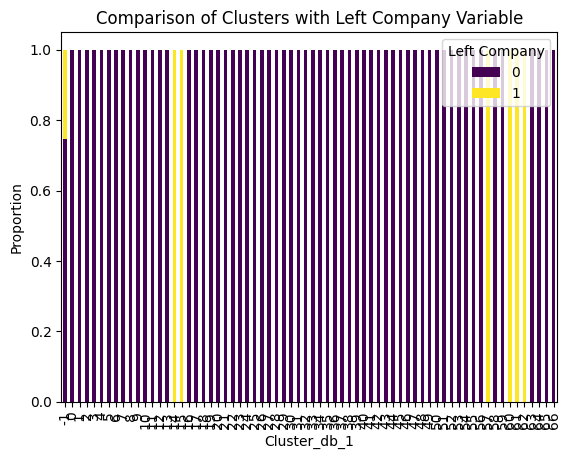

In [82]:
comparison_df = data[['Cluster_db_1', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_1'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_1')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [83]:
X_cluster.groupby('Cluster_db_1').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,Cluster_kmeans_6,Cluster_ac2,Cluster_ac3,Cluster_ac4,Cluster_ac5,Cluster_ac6
Cluster_db_1,,,,,,,,,,,,,,,,
-1,0.497294,0.40784,0.434967,0.293799,0.697356,0.25433,1.671832,1.768459,0.2835,0.25433,1.969006,0.74567,0.260711,1.04649,1.748405,1.724704
0,0.265945,0.00000,0.207676,0.067838,0.228005,0.00000,4.000000,0.000000,0.0000,0.00000,4.000000,1.00000,0.000000,1.00000,0.000000,5.000000
1,0.290706,0.20000,0.234748,0.065753,0.170541,0.00000,4.000000,0.000000,0.0000,0.00000,4.000000,1.00000,0.000000,1.00000,0.000000,5.000000
2,0.182292,0.40000,0.183637,0.065860,0.891228,0.00000,0.000000,0.000000,0.0000,0.00000,0.000000,1.00000,0.000000,1.00000,0.000000,3.000000
3,0.052083,0.60000,0.131231,0.074633,0.900000,0.00000,0.000000,0.000000,0.0000,0.00000,0.000000,1.00000,0.000000,1.00000,0.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.881989,0.40000,0.701720,0.066175,0.913865,1.00000,1.000000,1.000000,1.0000,1.00000,1.000000,0.00000,1.000000,3.00000,1.000000,0.000000
63,0.902125,0.20000,0.732150,0.530780,0.610400,0.00000,3.000000,3.000000,0.0000,0.00000,3.000000,1.00000,0.000000,0.00000,4.000000,4.000000
64,0.820625,0.00000,0.326542,0.546469,0.421333,0.00000,0.000000,0.000000,0.0000,0.00000,0.000000,1.00000,0.000000,1.00000,0.000000,3.000000


### k-distance graph

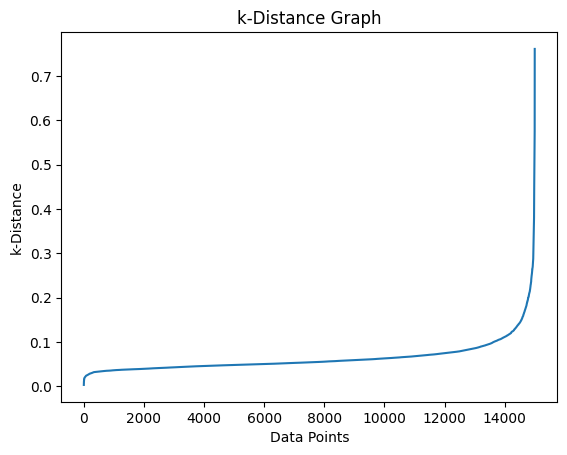

In [84]:
# estimating eps value 
k = 4  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [85]:

eps = 0.2  
min_samples = 5

#Run DBSCAN and evaluate
db_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
core_samples_mask = np.zeros_like(db_2.labels_, dtype=bool)
core_samples_mask[db_2.core_sample_indices_] = True
labels = db_2.labels_
data['Cluster_db_2'] = db_2.fit_predict(X_scaled)
X_cluster['Cluster_db_2']=data['Cluster_db_2']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_2.fit_predict(X_scaled)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

Silhouette Score: 0.9047055191392898


In [86]:
cluster_distribution = data['Cluster_db_2'].value_counts().sort_index()
cluster_distribution

Cluster_db_2
-1      184
 0      542
 1        6
 2       30
 3      244
       ... 
 134      8
 135     10
 136      7
 137      9
 138      5
Name: count, Length: 140, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_db_2                    
-1            0.793478  0.206522
 0            1.000000  0.000000
 1            1.000000  0.000000
 2            1.000000  0.000000
 3            1.000000  0.000000
...                ...       ...
 134          1.000000  0.000000
 135          1.000000  0.000000
 136          0.000000  1.000000
 137          1.000000  0.000000
 138          1.000000  0.000000

[140 rows x 2 columns]


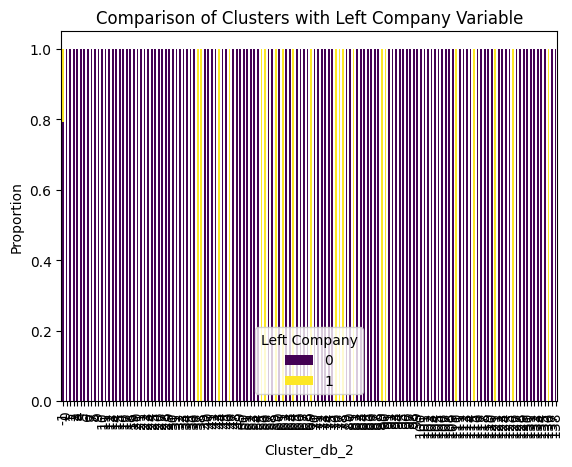

In [87]:
comparison_df = data[['Cluster_db_2', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_2'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_2')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [88]:
X_cluster.groupby('Cluster_db_2').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,Cluster_kmeans_6,Cluster_ac2,Cluster_ac3,Cluster_ac4,Cluster_ac5,Cluster_ac6,Cluster_db_1
Cluster_db_2,,,,,,,,,,,,,,,,,
-1,0.508662,0.318478,0.431380,0.292719,0.671377,0.206522,1.603261,1.728261,0.293478,0.206522,2.070652,0.793478,0.244565,0.956522,1.608696,2.097826,-1.0
0,0.290706,0.200000,0.234748,0.065753,0.170541,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,0.000000,5.000000,1.0
1,0.031250,0.000000,0.826324,0.301200,0.611111,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,-1.0
2,0.190104,0.800000,0.642679,0.261431,0.583333,0.000000,3.000000,3.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,3.000000,1.000000,-1.0
3,0.265945,0.000000,0.207676,0.067838,0.228005,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,0.000000,5.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,0.939453,0.800000,0.859229,0.508650,0.566667,0.000000,3.000000,3.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,4.000000,4.000000,-1.0
135,0.907813,0.800000,0.240654,0.543693,0.440000,0.000000,3.000000,3.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,4.000000,4.000000,66.0
136,0.939732,0.000000,0.783044,0.046990,0.952381,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,1.000000,0.000000,-1.0


### k-distance graph

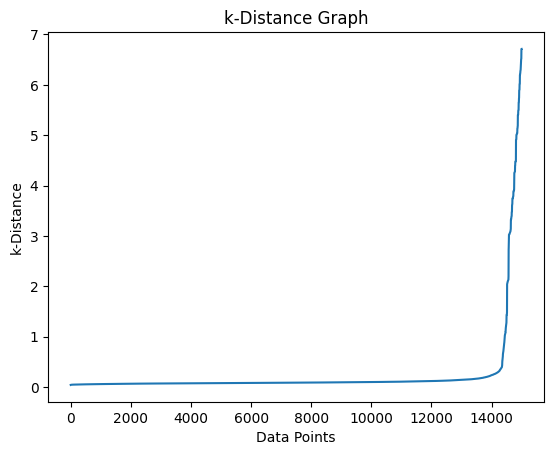

In [89]:
# estimating eps value 
k = 14  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [90]:

eps = 0.5  # the one for 5 features: 0.375
min_samples = 15

#Run DBSCAN and evaluate
db_3 = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
core_samples_mask = np.zeros_like(db_3.labels_, dtype=bool)
core_samples_mask[db_3.core_sample_indices_] = True
labels = db_3.labels_
data['Cluster_db_3'] = db_3.fit_predict(X_scaled) 
X_cluster['Cluster_db_3']=data['Cluster_db_3']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_3.fit_predict(X_scaled)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

Silhouette Score: 0.8699169041632018


In [91]:
cluster_distribution = data['Cluster_db_3'].value_counts().sort_index()
cluster_distribution

Cluster_db_3
-1     627
 0     542
 1      21
 2      30
 3     244
      ... 
 76     28
 77     18
 78    250
 79     25
 80     16
Name: count, Length: 82, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_db_3                    
-1            0.824561  0.175439
 0            1.000000  0.000000
 1            1.000000  0.000000
 2            1.000000  0.000000
 3            1.000000  0.000000
...                ...       ...
 76           1.000000  0.000000
 77           0.000000  1.000000
 78           1.000000  0.000000
 79           1.000000  0.000000
 80           1.000000  0.000000

[82 rows x 2 columns]


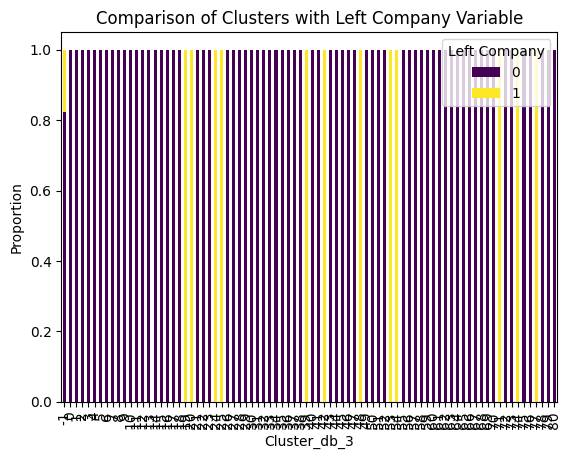

In [92]:
comparison_df = data[['Cluster_db_3', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_3'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_3')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [93]:
X_cluster.groupby('Cluster_db_3').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,Cluster_kmeans_6,Cluster_ac2,Cluster_ac3,Cluster_ac4,Cluster_ac5,Cluster_ac6,Cluster_db_1,Cluster_db_2
Cluster_db_3,,,,,,,,,,,,,,,,,,
-1,0.447344,0.388198,0.421708,0.283478,0.683360,0.175439,1.633174,1.814992,0.226475,0.175439,1.663477,0.824561,0.186603,0.894737,1.62201,1.952153,2.819777,51.035088
0,0.290706,0.200000,0.234748,0.065753,0.170541,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,0.00000,5.000000,1.000000,0.000000
1,0.116071,0.600000,0.436582,0.256584,0.903175,0.000000,0.000000,3.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,3.00000,1.000000,-1.000000,8.000000
2,0.190104,0.800000,0.642679,0.261431,0.583333,0.000000,3.000000,3.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,3.00000,1.000000,-1.000000,2.000000
3,0.265945,0.000000,0.207676,0.067838,0.228005,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,0.00000,5.000000,0.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.872210,0.000000,0.226802,0.514838,0.527381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,3.000000,-1.000000,123.000000
77,0.813368,0.000000,0.406282,0.067289,0.925926,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,1.00000,0.000000,-1.000000,121.000000
78,0.902125,0.200000,0.732150,0.530780,0.610400,0.000000,3.000000,3.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,4.00000,4.000000,63.000000,122.000000


### k-distance graph

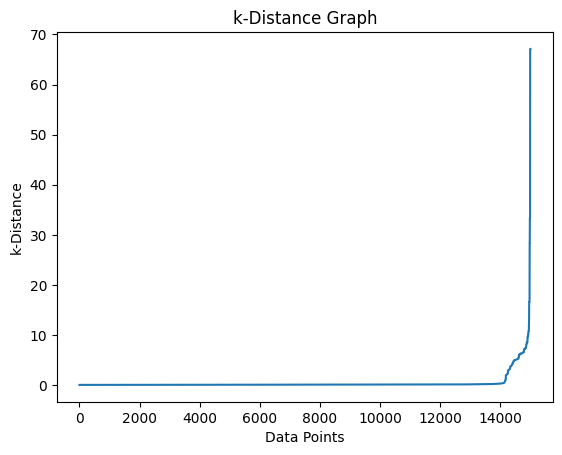

In [94]:
# estimating eps value 
k = 19  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [95]:

eps = 0.375  
min_samples = 20

#Run DBSCAN and evaluate
db_4 = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
core_samples_mask = np.zeros_like(db_4.labels_, dtype=bool)
core_samples_mask[db_4.core_sample_indices_] = True
labels = db_4.labels_
data['Cluster_db_4'] = db_4.fit_predict(X_scaled)
X_cluster['Cluster_db_4']=data['Cluster_db_4']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_4.fit_predict(X_scaled)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

Silhouette Score: 0.8535026845269927


In [96]:
cluster_distribution = data['Cluster_db_4'].value_counts().sort_index()
cluster_distribution

Cluster_db_4
-1     879
 0     542
 1      21
 2      30
 3     244
      ... 
 61    237
 62     32
 63    250
 64     25
 65     28
Name: count, Length: 67, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_db_4                    
-1            0.833902  0.166098
 0            1.000000  0.000000
 1            1.000000  0.000000
 2            1.000000  0.000000
 3            1.000000  0.000000
...                ...       ...
 61           0.000000  1.000000
 62           1.000000  0.000000
 63           1.000000  0.000000
 64           1.000000  0.000000
 65           1.000000  0.000000

[67 rows x 2 columns]


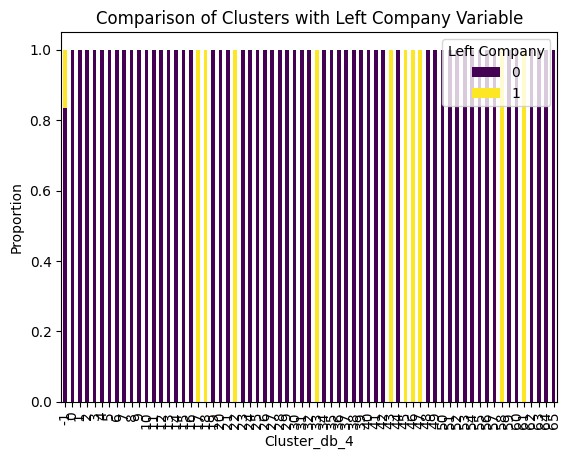

In [97]:
comparison_df = data[['Cluster_db_4', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_4'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_4')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [98]:
X_cluster.groupby('Cluster_db_4').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,Cluster_kmeans_6,Cluster_ac2,Cluster_ac3,Cluster_ac4,Cluster_ac5,Cluster_ac6,Cluster_db_1,Cluster_db_2,Cluster_db_3
Cluster_db_4,,,,,,,,,,,,,,,,,,,
-1,0.474580,0.380887,0.416207,0.295692,0.681153,0.166098,1.703072,1.779295,0.202503,0.166098,1.845279,0.833902,0.174061,0.858931,1.698521,2.004551,6.833902,59.977247,14.535836
0,0.290706,0.200000,0.234748,0.065753,0.170541,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,0.000000,5.000000,1.000000,0.000000,0.000000
1,0.116071,0.600000,0.436582,0.256584,0.903175,0.000000,0.000000,3.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,3.000000,1.000000,-1.000000,8.000000,1.000000
2,0.190104,0.800000,0.642679,0.261431,0.583333,0.000000,3.000000,3.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,3.000000,1.000000,-1.000000,2.000000,2.000000
3,0.265945,0.000000,0.207676,0.067838,0.228005,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,0.000000,5.000000,0.000000,3.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.815533,1.000000,0.864052,0.063598,0.915190,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,1.000000,0.000000,61.000000,115.000000,74.000000
62,0.800781,0.000000,0.524971,0.534383,0.562500,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,1.000000,-1.000000,117.000000,75.000000
63,0.902125,0.200000,0.732150,0.530780,0.610400,0.000000,3.000000,3.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,4.000000,4.000000,63.000000,122.000000,78.000000


### k-distance graph

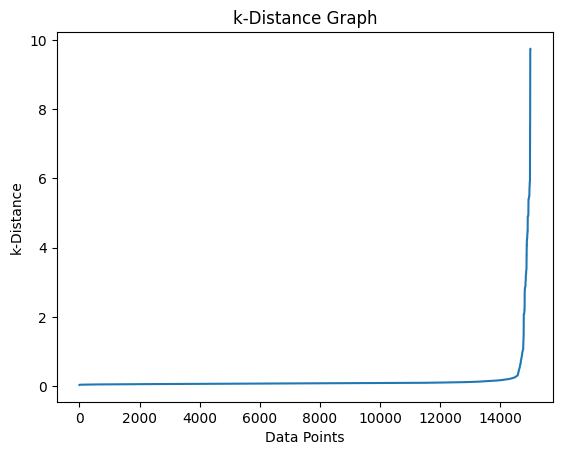

In [99]:
# estimating eps value 
k = 9  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [100]:

eps = 0.2  
min_samples = 6

#Run DBSCAN and evaluate
db_5 = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
core_samples_mask = np.zeros_like(db_5.labels_, dtype=bool)
core_samples_mask[db_5.core_sample_indices_] = True
labels = db_5.labels_
data['Cluster_db_5'] = db_5.fit_predict(X_scaled) 
X_cluster['Cluster_db_5']=data['Cluster_db_5']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_5.fit_predict(X_scaled)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

Silhouette Score: 0.918959966222074


In [101]:
cluster_distribution = data['Cluster_db_5'].value_counts().sort_index()
cluster_distribution

Cluster_db_5
-1      269
 0      542
 1       30
 2      244
 3        6
       ... 
 120     10
 121      7
 122     11
 123      6
 124      3
Name: count, Length: 126, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_db_5                    
-1            0.814126  0.185874
 0            1.000000  0.000000
 1            1.000000  0.000000
 2            1.000000  0.000000
 3            1.000000  0.000000
...                ...       ...
 120          1.000000  0.000000
 121          0.000000  1.000000
 122          0.000000  1.000000
 123          1.000000  0.000000
 124          1.000000  0.000000

[126 rows x 2 columns]


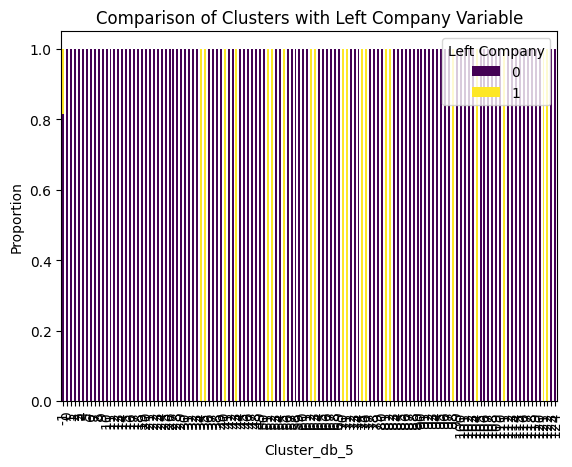

In [102]:
comparison_df = data[['Cluster_db_5', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_5'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_5')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [103]:
X_cluster.groupby('Cluster_db_5').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,Cluster_kmeans_6,Cluster_ac2,Cluster_ac3,Cluster_ac4,Cluster_ac5,Cluster_ac6,Cluster_db_1,Cluster_db_2,Cluster_db_3,Cluster_db_4
Cluster_db_5,,,,,,,,,,,,,,,,,,,,
-1,0.508887,0.356877,0.415818,0.301599,0.679926,0.185874,1.330855,1.929368,0.245353,0.185874,2.0,0.814126,0.211896,0.881041,1.717472,2.003717,-1.0,27.074349,2.345725,-0.189591
0,0.290706,0.200000,0.234748,0.065753,0.170541,0.000000,4.000000,0.000000,0.000000,0.000000,4.0,1.000000,0.000000,1.000000,0.000000,5.000000,1.0,0.000000,0.000000,0.000000
1,0.190104,0.800000,0.642679,0.261431,0.583333,0.000000,3.000000,3.000000,0.000000,0.000000,5.0,1.000000,0.000000,0.000000,3.000000,1.000000,-1.0,2.000000,2.000000,2.000000
2,0.265945,0.000000,0.207676,0.067838,0.228005,0.000000,4.000000,0.000000,0.000000,0.000000,4.0,1.000000,0.000000,1.000000,0.000000,5.000000,0.0,3.000000,3.000000,3.000000
3,0.041667,0.600000,0.817757,0.316556,0.566667,0.000000,0.000000,3.000000,0.000000,0.000000,5.0,1.000000,0.000000,0.000000,3.000000,1.000000,-1.0,4.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0.907813,0.800000,0.240654,0.543693,0.440000,0.000000,3.000000,3.000000,0.000000,0.000000,3.0,1.000000,0.000000,0.000000,4.000000,4.000000,66.0,135.000000,-1.000000,-1.000000
121,0.939732,0.000000,0.783044,0.046990,0.952381,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,1.000000,3.000000,1.000000,0.000000,-1.0,136.000000,-1.000000,-1.000000
122,0.893466,0.600000,0.275276,0.071952,0.915152,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,1.000000,3.000000,1.000000,0.000000,-1.0,126.000000,-1.000000,-1.000000


## Gaussian mixtures clustering

### Determining the optimal number of clusters

Text(0.5, 0, 'Number Of Component')

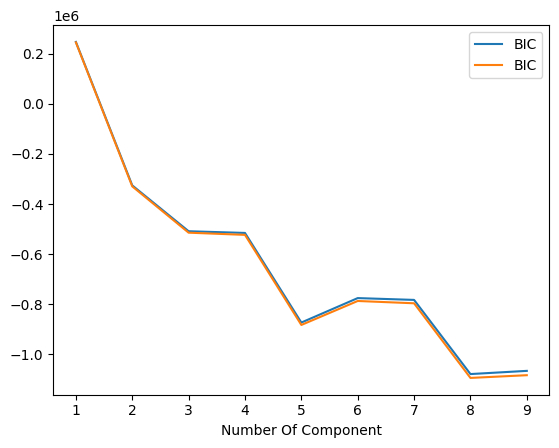

In [104]:
#Prepare
n_conponent = np.arange(1,10)

#Create GGM Model
models = [GaussianMixture(n_components = n,
                          random_state=42).fit(X_scaled) for n in n_conponent]
#Plot
plt.plot(n_conponent,
         [m.bic(X_scaled) for m in models],
         label = 'BIC')
plt.plot(n_conponent,
         [m.aic(X_scaled) for m in models],
         label = 'BIC')
plt.legend()
plt.xlabel("Number Of Component")

In [105]:
# create GM Models
model_gauss = GaussianMixture(n_components=4,
                        random_state=42).fit(X_scaled)
cluster_Gaussian_1 = pd.Series(model_gauss.predict(X_scaled))
X_cluster['cluster_Gaussian_1'] = cluster_Gaussian_1
X_cluster

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,...,Cluster_ac3,Cluster_ac4,Cluster_ac5,Cluster_ac6,Cluster_db_1,Cluster_db_2,Cluster_db_3,Cluster_db_4,Cluster_db_5,cluster_Gaussian_1
0,0.0,0.2,0.336449,0.112133,0.033333,0,4,0,0,0,...,0,1,0,5,1,0,0,0,0,0
1,0.0,0.6,0.294393,0.132000,1.000000,0,0,3,0,0,...,0,0,3,1,-1,8,1,1,5,3
2,0.0,0.0,0.869159,0.292400,0.666667,0,4,0,0,0,...,0,1,0,3,-1,1,-1,-1,16,3
3,0.0,0.4,0.850467,0.299733,0.566667,0,0,3,0,0,...,0,1,0,3,-1,25,-1,-1,-1,2
4,0.0,0.8,0.747664,0.286533,0.666667,0,3,3,0,0,...,0,0,3,1,-1,2,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,1.0,0.4,0.728972,0.071733,0.933333,1,1,1,1,1,...,1,3,1,0,62,110,71,58,98,1
14995,1.0,0.4,0.635514,0.032933,0.966667,1,1,1,1,1,...,1,3,1,0,62,110,71,58,98,1
14996,1.0,0.6,0.682243,0.020667,0.933333,1,1,1,1,1,...,1,3,1,0,60,89,53,46,81,1
14997,1.0,0.6,0.593458,0.028000,0.866667,1,1,1,1,1,...,1,3,1,0,60,89,53,46,81,1


In [106]:
X_cluster.cluster_Gaussian_1.value_counts()

cluster_Gaussian_1
1    6893
3    4028
2    2093
0    1985
Name: count, dtype: int64

Comparison Table:
 left_company               0         1
cluster_Gaussian_1                    
0                   0.995466  0.004534
1                   0.715508  0.284492
2                   0.258481  0.741519
3                   0.987835  0.012165


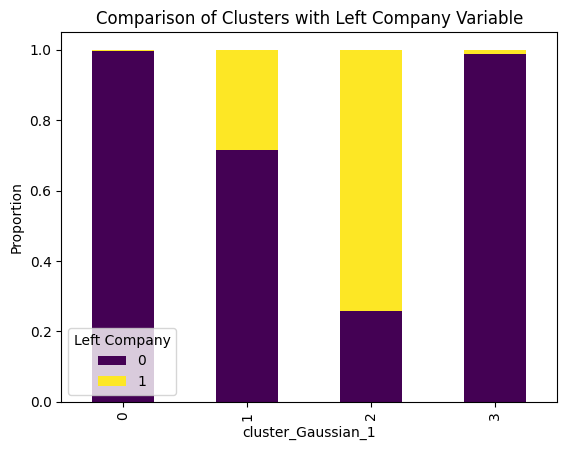

In [107]:
data['cluster_Gaussian_1'] = cluster_Gaussian_1
comparison_df = data[['cluster_Gaussian_1', 'left_company']]
comparison_table = pd.crosstab(comparison_df['cluster_Gaussian_1'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('cluster_Gaussian_1')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [108]:
X_cluster.groupby('cluster_Gaussian_1').mean()

,last_evaluation,number_project,average_montly_hours,sensor_stepcount,sensor_heartbeat,left_company,Cluster_kmeans_5,Cluster_kmeans_4,Cluster_kmeans_3,Cluster_kmeans_2,...,Cluster_ac2,Cluster_ac3,Cluster_ac4,Cluster_ac5,Cluster_ac6,Cluster_db_1,Cluster_db_2,Cluster_db_3,Cluster_db_4,Cluster_db_5
cluster_Gaussian_1,,,,,,,,,,,,,,,,,,,,,
0,0.351834,0.219345,0.333216,0.213218,0.445508,0.004534,1.621159,0.201008,0.009068,0.004534,...,0.995466,0.004534,0.945088,0.196474,3.664484,3.080101,8.425693,5.160202,4.070025,6.424181
1,0.727631,0.514145,0.607858,0.349000,0.691561,0.284492,2.169737,2.303061,0.284492,0.284492,...,0.715508,0.284492,0.896127,2.634702,1.795735,43.349630,85.703757,52.994922,43.851443,78.021616
2,0.273635,0.070521,0.291160,0.302553,0.338780,0.741519,1.851409,1.983278,1.477305,0.741519,...,0.258481,1.469661,1.734353,1.536073,2.204969,15.063545,40.197324,19.213091,17.200191,33.789775
3,0.511149,0.318222,0.472209,0.335384,0.651109,0.012165,0.278798,2.674777,0.012165,0.012165,...,0.987835,0.012165,0.146226,2.654667,1.231877,20.316038,46.560079,22.990318,19.730387,42.583168


# Function for deployment

In [110]:
# def predict_cluster(X_pred):
#libraries to be added
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA 
    """
    - Retrieve the original data
    - Clean and preprocess data
    - Reduce features #could still be a function in data
    - Apply PCA
    - Train model
    - Perform prediction
    - Return cluster accordingly; Cluster 1 and 2 are the ones of people tending to leave the company
    """
    print (X_pred)

    #Retrieve dataset from local directory
    data = pd.read_csv(DATA_HR)

    # Clean data using data.py
    data = clean_data_leaving(data)
    X_pred = clean_data_leaving(X_pred)

    # Create X and y
    X = data.drop(columns=['left_company']) # there could be performance optimization if we select just the relevant features here, but could bring issues for data cleaning and scaling --> time constrains

    # reducing features to the relevant ones: could be an own function in data.py
    # Apply feature preprocessing
    X_preproc = preprocess_features_leaving(X)
    X_pred_preproc = preprocess_features_leaving(X_pred)

    # def feature_selection (X_pred):
    selected_features = ['last_evaluation', 'number_project', 'average_montly_hours', 'sensor_stepcount','sensor_heartbeat'] #'time_spend_company'
    X_preproc = X_preproc[selected_features]
    X_pred_preproc = X_pred_preproc[selected_features]
    X_pred_preproc_index = X_pred_preproc.index

    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_preproc)

    # Apply KMeans and train model
    model_kmeans = KMeans(n_clusters=3, random_state=42)
    model_kmeans.fit(X_pca)

    # predicting the clusters
    X_pred_cluster= model_kmeans.predict(X_pred_preproc)
    # breakpoint()
    cluster = pd.DataFrame(X_pred_cluster,
                              columns = ['Cluster_kmeans_3'],
                              index=X_pred_preproc_index)
    
    # Merging input features with prediction for visualization
    X_test_final = pd.merge(X_pred, cluster,
                            left_index=True, right_index=True)
   

IndentationError: unexpected indent (3861091047.py, line 5)